# Regularising Measurements 

In [1]:
%load_ext nb_black
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from typing import List, Dict
import pymc3 as pm

import seaborn as sns
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["font.size"] = 15

<IPython.core.display.Javascript object>

## Step 0: Read the data

In [5]:
data = pd.read_csv("sample.csv")
data.head()

,category,assets,pct
0,Fantasy,asset_1,0.059191
1,Children,asset_2,1.047079
2,Sports,asset_3,0.272123
3,Children,asset_6,0.688560
4,SciFi,asset_7,0.295703


<IPython.core.display.Javascript object>

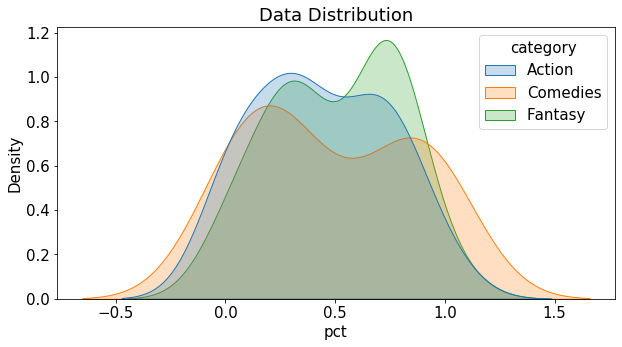

<IPython.core.display.Javascript object>

In [6]:
is_sample = data["category"].isin(["Action", "Comedies", "Fantasy"])
df_samp = data[is_sample]

sns.kdeplot(
    data=df_samp.sort_values(by="category"),
    x="pct",
    hue="category",
    common_norm=False,
    shade=True,
)
plt.title("Data Distribution")
plt.show()

## Step 1: Set priors for the different categories

,category,mu0,n0,alpha,beta,prior_precision,prior_std
0,Action,0.2,5.0,60.0,1.0,60.0,0.016667
1,Comedies,0.2,5.0,60.0,1.0,60.0,0.016667
2,Fantasy,0.2,5.0,60.0,1.0,60.0,0.016667


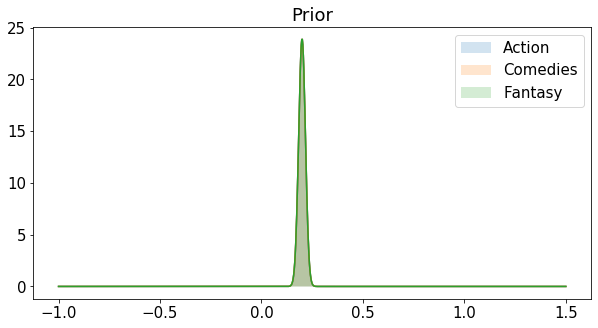

<IPython.core.display.Javascript object>

In [16]:
priors = {
    "Action": {"mu0": 0.2, "n0": 5, "alpha": 60, "beta": 1,},
    "Comedies": {"mu0": 0.2, "n0": 5, "alpha": 60, "beta": 1,},
    "Fantasy": {"mu0": 0.2, "n0": 5, "alpha": 60, "beta": 1,},
}

df_prior = (
    pd.DataFrame(priors).T.reset_index().rename(columns={"index": "category"})
).assign(
    **{
        "prior_precision": lambda x: x["alpha"] / x["beta"],
        "prior_std": lambda x: 1 / x["prior_precision"],
    }
)

display(df_prior)

x = np.linspace(-1, 1.5, 1000)


for g, df in df_prior.groupby("category"):
    p_gaussian_0 = norm.pdf(x, loc=df["mu0"].values[0], scale=df["prior_std"].values[0])
    plt.plot(x, p_gaussian_0)
    plt.fill_between(x, 0, p_gaussian_0, alpha=0.2, label=g)
    plt.legend()
plt.title("Prior")
plt.show()

## Step 2: Calculate mean and variance from the data

In [9]:
def calc_sample_stats(df: pd.DataFrame, val: str, agg_lvl: List[str]) -> pd.DataFrame:
    """Regularises by hierarchy"""
    df_sample_stats = (
        df.groupby(agg_lvl)
        .agg(
            **{
                "sample_mean": (val, np.mean),
                "sample_var": (val, np.var),
                "n": (val, "count"),
            }
        )
        .assign(**{"sample_precision": lambda x: 1 / x["sample_var"]})
    ).reset_index()
    return df_sample_stats


df_sample_stats = calc_sample_stats(df_samp, val="pct", agg_lvl=["category"])
df_sample_stats

,category,sample_mean,sample_var,n,sample_precision
0,Action,0.440048,0.091924,26,10.878507
1,Comedies,0.482717,0.140495,15,7.117695
2,Fantasy,0.504858,0.083210,22,12.017799


<IPython.core.display.Javascript object>

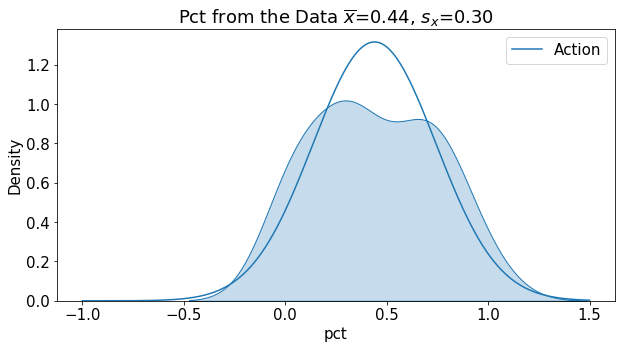

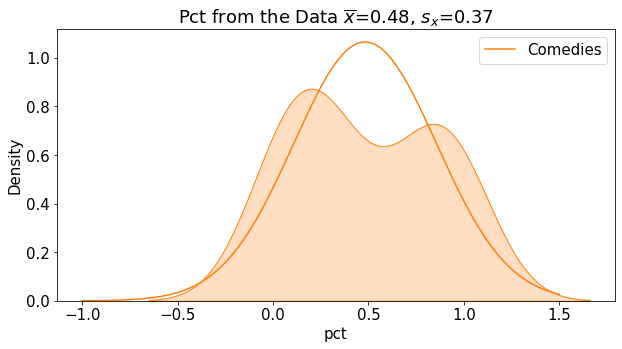

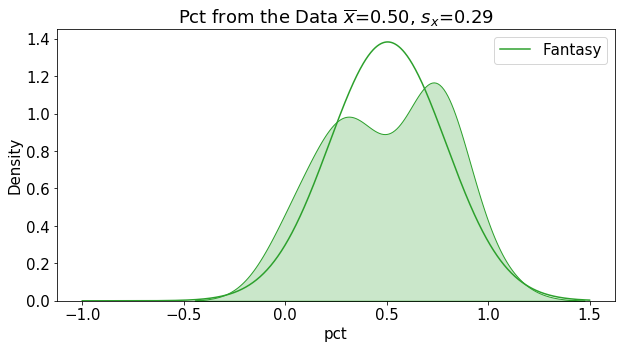

<IPython.core.display.Javascript object>

In [10]:
colours = {
    "Action": "tab:blue",
    "Comedies": "tab:orange",
    "Fantasy": "tab:green",
    "Thrillers": "tab:red",
}


for g, df in df_sample_stats.groupby("category"):

    sns.kdeplot(
        data=df_samp[df_samp["category"] == g], x="pct", shade=True, color=colours[g],
    )

    p_gaussian_x = norm.pdf(
        x,
        loc=df["sample_mean"].values[0],
        scale=1 / np.sqrt(df["sample_precision"].values[0]),
    )
    plt.plot(x, p_gaussian_x, label=g, color=colours[g])
    plt.title(
        "Pct from the Data $ \overline{x}$"
        + "={z:.2f}, $s_x$={y:.2f}".format(
            z=df["sample_mean"].values[0],
            y=1 / np.sqrt(df["sample_precision"].values[0]),
        )
    )

    plt.legend()
    plt.show()

## Step 3: Calculate posterior distribution

In [11]:
def update_posterior(
    df_sample_stats: pd.DataFrame, df_prior: pd.DataFrame, agg_lvl: List[str]
) -> pd.DataFrame:
    """Update posterior distribution parameters"""
    df_with_prior = df_sample_stats.merge(
        df_prior, on=agg_lvl, how="left", validate="m:1"
    )
    df_with_prior = df_with_prior.assign(
        **{
            "posterior_alpha": lambda x: x["alpha"] + x["n"] / 2,
            "posterior_beta": lambda x: x["beta"]
            + (0.5 * x["sample_var"] * x["n"])
            + (0.5 * x["n"] * x["n0"] / (x["n"] + x["n0"]))
            * (x["sample_mean"] - x["mu0"]) ** 2,
            "posterior_mean": lambda x: (x["n"] / (x["n"] + x["n0"])) * x["sample_mean"]
            + (x["n0"] / (x["n"] + x["n0"])) * x["mu0"],
            "posterior_precision": lambda x: x["posterior_alpha"] / x["posterior_beta"],
        }
    )
    return df_with_prior


post = update_posterior(df_sample_stats, df_prior, agg_lvl=["category"])
post

,category,sample_mean,sample_var,n,sample_precision,mu0,n0,alpha,beta,prior_precision,prior_std,posterior_alpha,posterior_beta,posterior_mean,posterior_precision
0,Action,0.440048,0.091924,26,10.878507,0.2,5.0,60.0,1.0,60.0,0.016667,73.0,2.315839,0.401330,31.522052
1,Comedies,0.482717,0.140495,15,7.117695,0.2,5.0,60.0,1.0,60.0,0.016667,67.5,2.203578,0.412038,30.631994
2,Fantasy,0.504858,0.083210,22,12.017799,0.2,5.0,60.0,1.0,60.0,0.016667,71.0,2.104628,0.448403,33.735171


<IPython.core.display.Javascript object>

#### Step 3a: Plot the posterior distributions

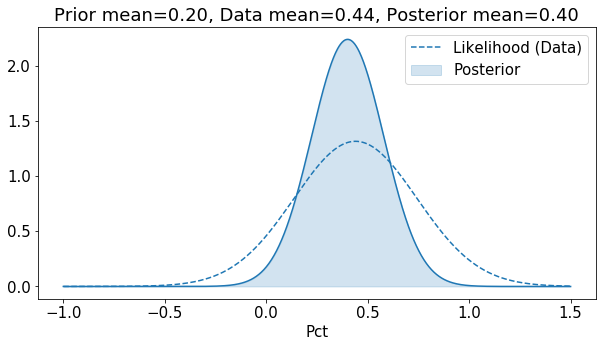

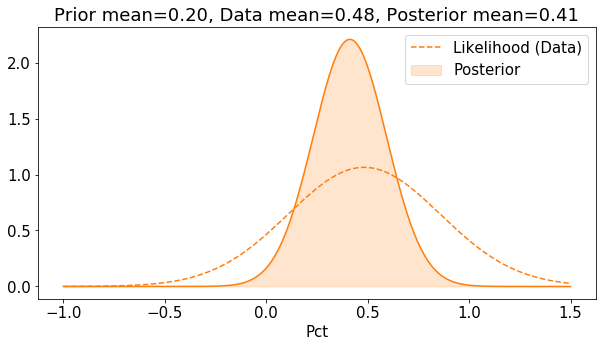

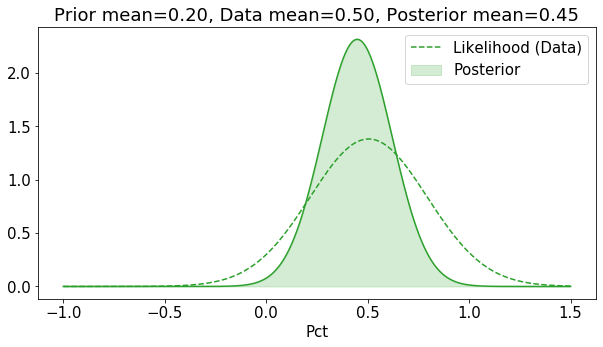

<IPython.core.display.Javascript object>

In [12]:


for g, df_post in post.groupby("category"):
    # prior      
    p_gaussian_0 = norm.pdf(x, loc=df_post["mu0"].values[0], scale=df_post["prior_std"].values[0])
    # likelihood
    p_gaussian_1 = norm.pdf(x, loc=df_post["sample_mean"].values[0], scale=np.sqrt(df_post["sample_var"].values[0]))
    # posterior      
    p_gaussian_2 = norm.pdf(
        x, loc=df_post["posterior_mean"], scale=1 / np.sqrt(df_post["posterior_precision"].values[0])
    )
#     plt.plot(x, p_gaussian_0, label="Prior", color="gray")

    plt.plot(x, p_gaussian_1, label="Likelihood (Data)", color=colours[g], linestyle="--")

    plt.plot(x, p_gaussian_2, color=colours[g])
    plt.fill_between(x, 0, p_gaussian_2, color=colours[g], alpha=0.2, label="Posterior")

    plt.legend()
    plt.title(
        "Prior mean={x:.2f}, Data mean={y:.2f}, Posterior mean={z:.2f}".format(
            x=df_post["mu0"].values[0],
            y=df_post["sample_mean"].values[0],
            z=df_post["posterior_mean"].values[0],
        )
    )
    plt.xlabel("Pct")
    plt.show()


## Step 4: Convert measurements to reflect the new posterior mean and variance
### Option 1: Use z-scores to convert (since the data is assumed to be Gaussian)

In [13]:
def update_values(
    df: pd.DataFrame, posterior: pd.DataFrame, val: str, agg_lvl: List[str]
) -> pd.DataFrame:
    df = df.merge(posterior, on=agg_lvl, how="left", validate="m:1").assign(
        **{
            "z_old": lambda x: np.sqrt(x["sample_precision"])
            * (x[val] - x["sample_mean"]),
            f"new_{val}": lambda x: (x["z_old"] / np.sqrt(x["posterior_precision"]))
            + x["posterior_mean"],
        }
    )
    return df


df_samp_updated = update_values(df_samp, post, val="pct", agg_lvl=["category"],)

<IPython.core.display.Javascript object>

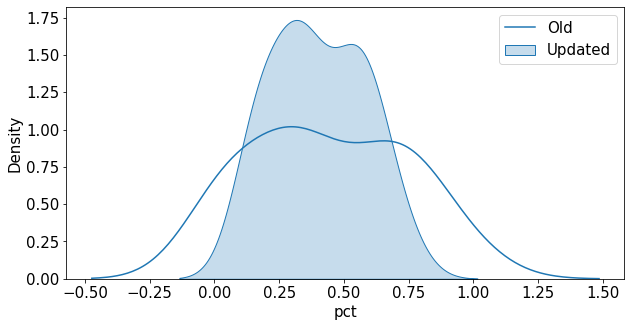

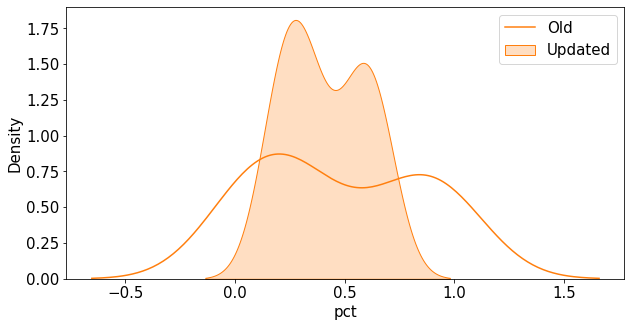

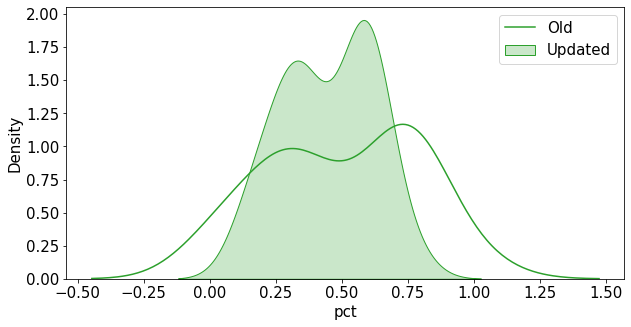

<IPython.core.display.Javascript object>

In [14]:
for g, df in df_samp_updated.groupby("category"):
    sns.kdeplot(
        df["pct"], shade=False, color=colours[g], label="Old",
    )
    sns.kdeplot(
        df["new_pct"], shade=True, color=colours[g], label="Updated",
    )
    plt.legend()
    plt.show()

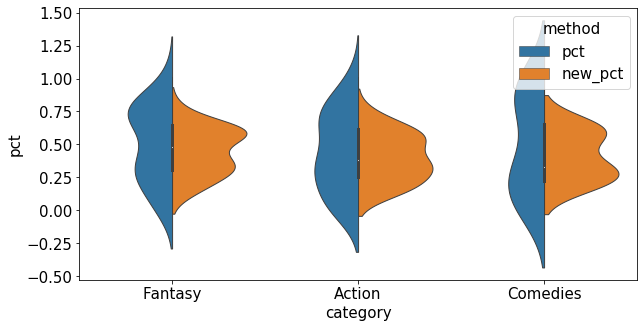

<IPython.core.display.Javascript object>

In [15]:
df_violin = df_samp_updated.melt(
    id_vars=["category", "assets"],
    value_vars=["pct", "new_pct",],
    var_name="method",
    value_name="pct",
)

sns.violinplot(
    data=df_violin,
    y="pct",
    x="category",
    hue="method",
    split=True,
    linewidth=1,
    alpha=0.1,
)